# Tutorial 2 - Poisson GLM with Spike History and Coupling

 This is an interactive tutorial designed to walk you through the steps of
 fitting an autoregressive Poisson GLM (i.e., a spiking GLM with
 spike-history) and a multivariate autoregressive Poisson GLM (i.e., a
 GLM with spike-history AND coupling between neurons).

 (Data from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details).
The dataset can be downloaded [here](https://pillowlab.princeton.edu/data/data_RGCs.zip):

The dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu).

*Last updated: Mar 10, 2020 (JW Pillow)*

 Instructions: Execute each section below separately using shift-enter.
 For detailed suggestions on how to interact with this tutorial, see
 header material in tutorial1_PoissonGLM.m


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.linalg import hankel

import statsmodels.api as sm

In [3]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size
refresh_rate = 1/dt_stim # refresh rate of the monitor
num_time_bins = stim.size # number of time bins in stimulus

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


In [16]:
### ==== 2. Bin the spike trains =========================
#
# For now we will assume we want to use the same time bin size as the time
# bins used for the stimulus. Later, though, we'll wish to vary this.
spikes_bin_centers = np.arange(num_time_bins+1) * dt_stim # centers of bins for applying to spike train
all_spikes_binned = np.zeros((num_time_bins, num_cells))
for neuron_idx, neuron in enumerate(all_spike_times):
    all_spikes_binned[:,neuron_idx] = np.histogram(neuron, spikes_bin_centers)[0]

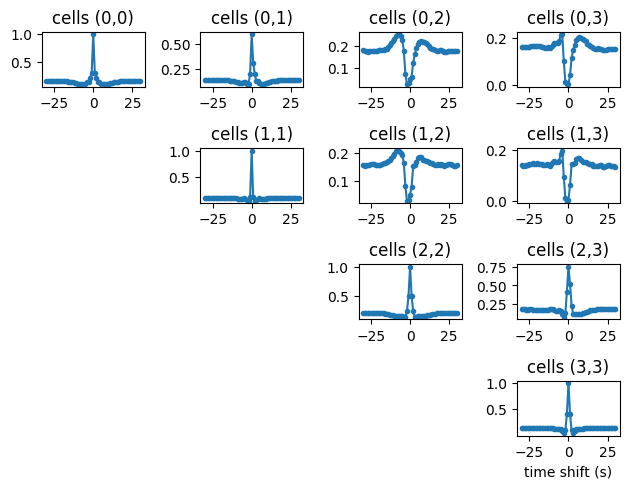

In [17]:
# Let's just visualize the spike-train auto and cross-correlations
# (Comment out this part if desired!)
fig = plt.figure()
num_lags = 30 # number of time-lags to use 
for i in range(num_cells):
    for j in range(i,num_cells):
        plt.subplot(num_cells, num_cells, i*num_cells+j+1)
        # matplotlib has a handy cross correlation plotting function
        plt.xcorr(all_spikes_binned[:,i], all_spikes_binned[:,j], maxlags=num_lags, usevlines=False, marker='.', linestyle='-')
#         xc = signal.correlate(all_spikes_binned[:,i], all_spikes_binned[:,j])
#         xc = xc[num_time_bins-1-num_lags:num_time_bins+num_lags]
#         if i==j:
#             xc[num_lags+1] = 0
#         plt.plot(xc)
        plt.title(f'cells ({i},{j})')
        plt.tight_layout()
plt.xlabel('time shift (s)')
plt.show()

In [12]:
### ==== 3. Build design matrix: single-neuron GLM with spike-history =========


# let's work with the third cell for now
cell_idx = 2
spikes_binned = all_spikes_binned[:,cell_idx]

# Set the number of time bins of stimulus to use for predicting spikes
ntfilt = 25     # Try varying this, to see how performance changes!
# Set number of time bins of auto-regressive spike-history to use
nthist = 20;

# Build stimulus design matrix (using 'hankel')
padded_stim = np.hstack((np.zeros(ntfilt-1), stim))   # pad early bins of stimulus with zero
design_mat_stim = hankel(padded_stim[:-ntfilt+1], stim[-ntfilt:])

# Build spike-history design matrix
padded_spikes = np.hstack((np.zeros(nthist), spikes_binned[:-1]))
# SUPER important: note that this doesn't include the spike count for the
# bin we're predicting? The spike train is shifted by one bin (back in
# time) relative to the stimulus design matrix
design_mat_spikes = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])

# Combine these into a single design matrix
design_mat = np.concatenate((design_mat_stim, design_mat_spikes), axis=1)

 Visualize the design matrix just to see what it looks like

The left part of the design matrix has the stimulus values, the right
part has the spike-history values.  The image on the right is the spike
count to be predicted.  Note that the spike-history portion of the design
matrix had better be shifted so that we aren't allowed to use the spike
count on this time bin to predict itself!

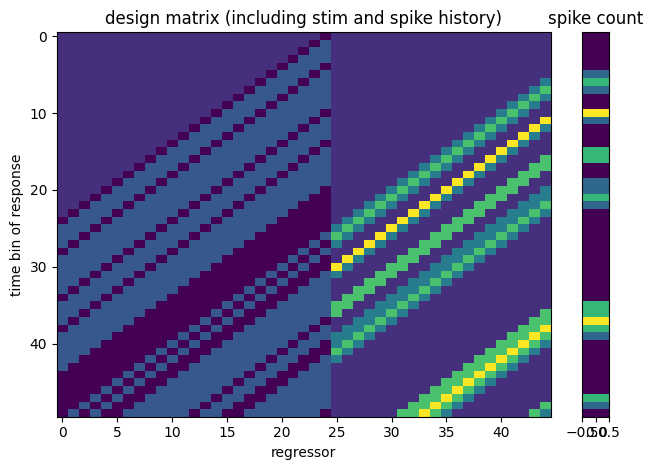

In [14]:
fig = plt.figure()
plt.subplot(1,10,(1,9))
plt.imshow(design_mat[:50], aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (including stim and spike history)')
plt.subplot(1,10,10)
plt.imshow(spikes_binned[:50,np.newaxis], aspect='auto', interpolation='nearest')
plt.yticks(ticks=[], labels=[])
plt.title('spike count')
plt.tight_layout()
plt.show()

In [6]:
### === 4. fit single-neuron GLM with spike-history ==================

design_mat_stim_offset = np.hstack((np.ones((num_time_bins,1)), design_mat_stim))     # just add a column of ones
# First fit GLM with no spike-history
print('Now fitting basic Poisson GLM...');
pGLM_model = sm.GLM(endog=spikes_binned, exog=design_mat_stim_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
pGLM_results = pGLM_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

design_mat_offset = np.hstack((np.ones((num_time_bins,1)), design_mat))
# Then fit GLM with spike history (now use Xdsgn design matrix instead of Xstim)
print('Now fitting Poisson GLM with spike-history...');
pGLMsh_model = sm.GLM(endog=spikes_binned, exog=design_mat_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
pGLMsh_results = pGLMsh_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLMsh_const = pGLMsh_results.params[0]
pGLMsh_filt = pGLMsh_results.params[1:ntfilt+1] # stimulus filter
pGLMsh_hist_filt = pGLMsh_results.params[ntfilt+1:] # spike history filter

Now fitting basic Poisson GLM...
Now fitting Poisson GLM with spike-history...


<Figure size 640x480 with 0 Axes>

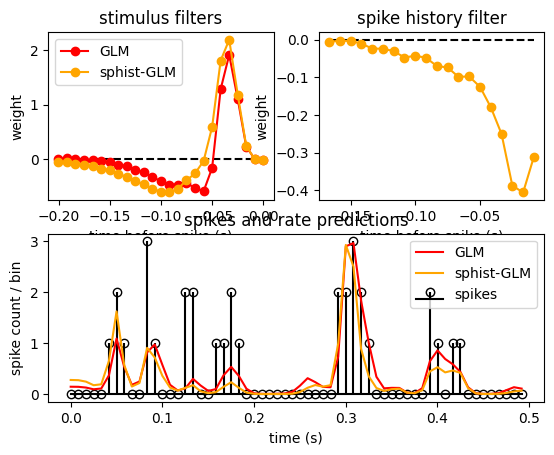

In [18]:
#  Make plots comparing filters
ttk = np.arange(-1*ntfilt+1,1)*dt_stim # time bins for stim filter
tth = np.arange(-1*nthist,0)*dt_stim # time bins for spike-history filter

plt.clf()
fig = plt.figure()
plt.subplot(221) # Plot stim filters
plt.plot(ttk,ttk*0, linestyle='--', c='k')
plt.plot(ttk,pGLM_filt, 'ro-', label='GLM')
plt.plot(ttk,pGLMsh_filt, 'o-', c='orange', label='sphist-GLM')
plt.legend(loc='upper left')
plt.title('stimulus filters')
plt.ylabel('weight')
plt.xlabel('time before spike (s)')

plt.subplot(222); # Plot spike history filter
plt.plot(tth,tth*0, linestyle='--', c='k')
plt.plot(tth,pGLMsh_hist_filt, 'o-', c='orange')
plt.title('spike history filter')
plt.xlabel('time before spike (s)')
plt.ylabel('weight')

### Plot predicted rate out of the two models

# Compute predicted spike rate on training data
rate_pred = np.exp(pGLM_const + design_mat_stim@pGLM_filt)
rate_pred_sh = np.exp(pGLMsh_const + design_mat@ pGLMsh_results.params[1:])

# Make plot
iiplot = np.arange(60)
ttplot = iiplot*dt_stim
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, spikes_binned[iiplot], linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
plt.plot(ttplot, rate_pred[iiplot], c='r', label ='GLM')
plt.plot(ttplot, rate_pred_sh[iiplot], c='orange', label='sphist-GLM')
plt.legend()
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.show()

<Figure size 640x480 with 0 Axes>

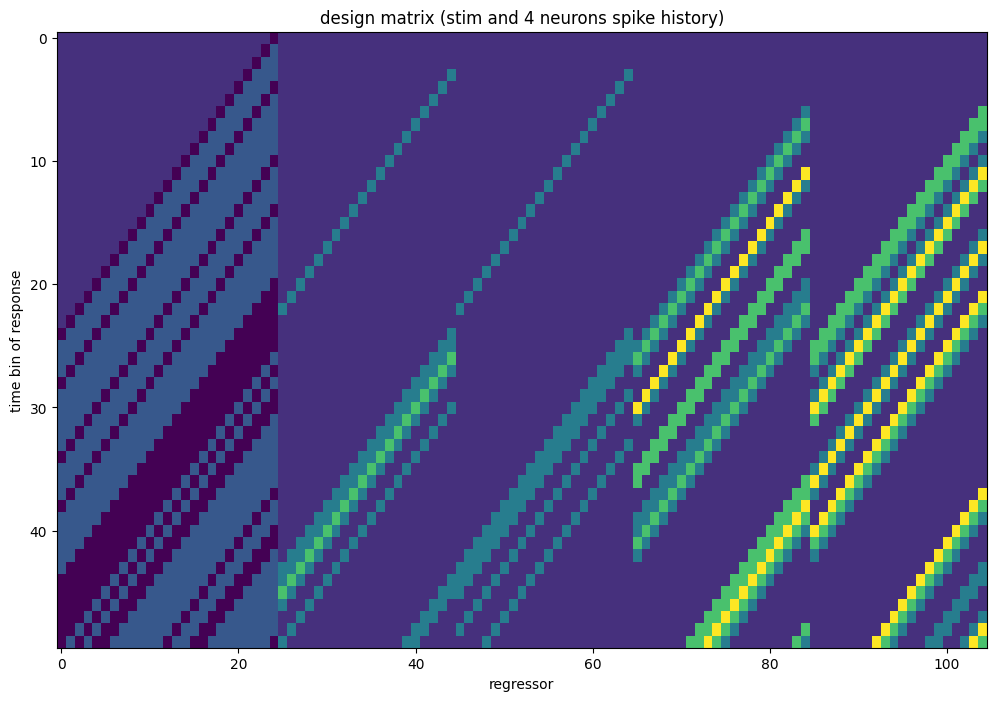

In [8]:
### === 5. fit coupled GLM for multiple-neuron responses ==================

# First step: build design matrix containing spike history for all neurons

design_mat_all_spikes = np.zeros((num_time_bins,nthist,num_cells)) # allocate space
# Loop over neurons to build design matrix, exactly as above
for j in np.arange(num_cells):
    padded_spikes = np.hstack((np.zeros(nthist), all_spikes_binned[:-1,j]))
    design_mat_all_spikes[:,:,j] = hankel(padded_spikes[:-nthist+1], padded_spikes[-nthist:])

# Reshape it to be a single matrix
design_mat_all_spikes = np.reshape(design_mat_all_spikes, (num_time_bins,-1), order='F')
design_mat_all = np.concatenate((design_mat_stim, design_mat_all_spikes), axis=1) # full design matrix (with all 4 neuron spike hist)

plt.clf() # Let's visualize 50 time bins of full design matrix
fig = plt.figure(figsize=[12,8])
plt.imshow(design_mat_all[:50], aspect='auto', interpolation='nearest')
plt.xlabel('regressor')
plt.ylabel('time bin of response')
plt.title('design matrix (stim and 4 neurons spike history)')
plt.show()

In [9]:
### Fit the model (stim filter, sphist filter, coupling filters) for one neuron 

print('Now fitting Poisson GLM with spike-history and coupling...');

design_mat_all_offset = np.hstack((np.ones((num_time_bins,1)), design_mat_all))     # just add a column of ones

pGLM_all_model = sm.GLM(endog=spikes_binned, exog=design_mat_all_offset,
                         family=sm.families.Poisson()) # assumes 'log' link.
pGLM_all_results = pGLM_all_model.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLM_all_const = pGLM_all_results.params[0]
pGLM_all_filt = pGLM_all_results.params[1:ntfilt+1] # stimulus filter
pGLM_all_hist_filt = pGLM_all_results.params[ntfilt+1:] # all cells spike history filter
pGLM_all_hist_filt = np.reshape(pGLM_all_hist_filt, (nthist,num_cells), order='F')


# So far all we've done is fit incoming stimulus and coupling filters for
# one neuron.  To fit a full population model, redo the above for each cell
# (i.e., to get incoming filters for 'cell_idx' = 1, 2, 3, and 4 in turn).

Now fitting Poisson GLM with spike-history and coupling...


<Figure size 640x480 with 0 Axes>

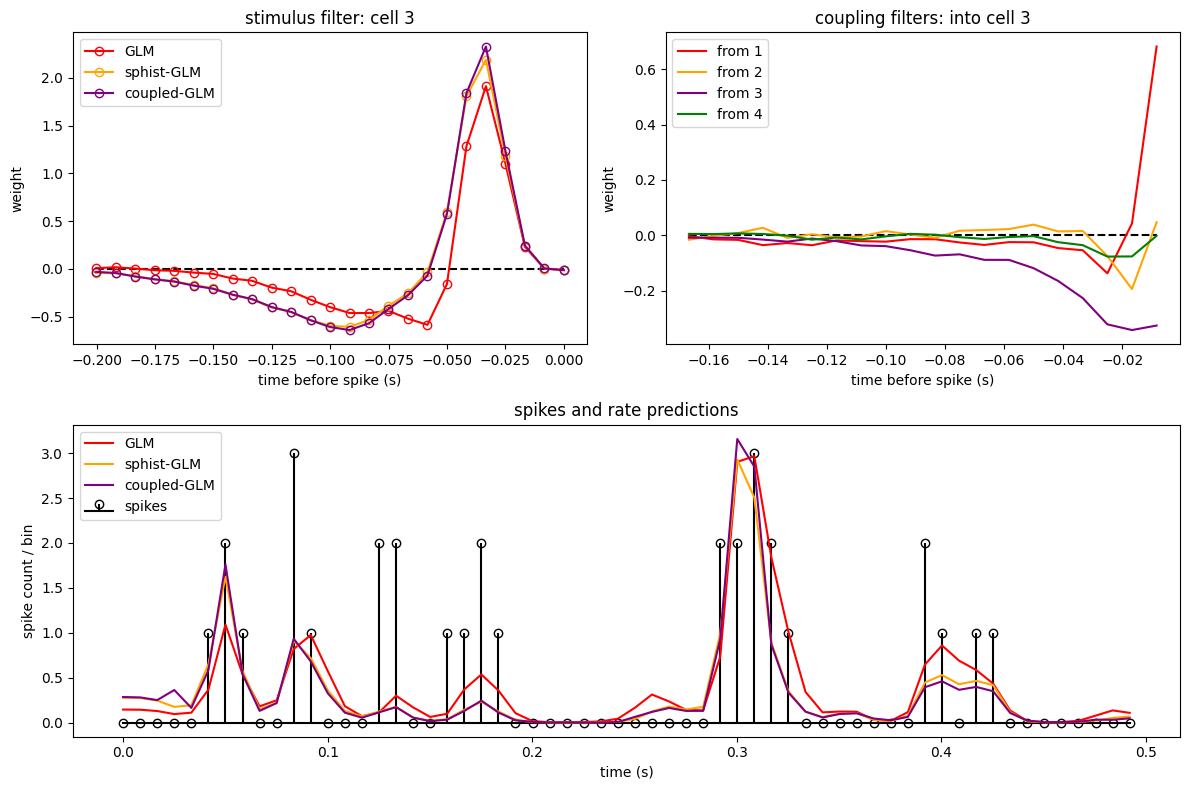

In [10]:
### Plot the fitted filters and rate prediction

plt.clf()
fig = plt.figure(figsize=[12,8])
plt.subplot(221) # Plot stim filters
plt.plot(ttk,ttk*0,'k--')
plt.plot(ttk, pGLM_filt, 'ro-', label='GLM', markerfacecolor='none')
plt.plot(ttk, pGLMsh_filt, 'o-', c='orange', label='sphist-GLM', markerfacecolor='none')
plt.plot(ttk,pGLM_all_filt, 'o-', c='purple', label='coupled-GLM', markerfacecolor='none')
plt.legend(loc='upper left')
plt.title(f'stimulus filter: cell {str(cell_idx+1)}')
plt.ylabel('weight');
plt.xlabel('time before spike (s)')

plt.subplot(222) # Plot spike history filter
plt.plot(tth,tth*0,'k--')
cs = ['r', 'orange', 'purple','g']
for i in np.arange(num_cells):
    plt.plot(tth,pGLM_all_hist_filt[:,i], c=cs[i], label='from ' + str(i+1))
plt.legend(loc='upper left')
plt.title(f'coupling filters: into cell {str(cell_idx+1)}')
plt.xlabel('time before spike (s)')
plt.ylabel('weight')

# Compute predicted spike rate on training data
rate_pred_all = np.exp(pGLM_all_const + design_mat_all @ pGLM_all_results.params[1:])

# Make plot
iiplot = np.arange(60)
ttplot = iiplot*dt_stim
plt.subplot(212)
markerline,_,_ = plt.stem(ttplot, spikes_binned[iiplot], linefmt='k-', basefmt='k-', label='spikes')
plt.setp(markerline, 'markerfacecolor', 'none')
plt.setp(markerline, 'markeredgecolor', 'k')
plt.plot(ttplot, rate_pred[iiplot], c='r', label ='GLM')
plt.plot(ttplot, rate_pred_sh[iiplot], c='orange', label='sphist-GLM')
plt.plot(ttplot, rate_pred_all[iiplot], c='purple', label='coupled-GLM')
plt.legend(loc='upper left')
plt.xlabel('time (s)')
plt.title('spikes and rate predictions')
plt.ylabel('spike count / bin')
plt.tight_layout()
plt.show()

In [11]:
### 6. Model comparison: log-likelihoood and AIC

# Let's compute loglikelihood (single-spike information) and AIC to see how
# much we gain by adding each of these filter types in turn:

LL_stimGLM = spikes_binned.T @ np.log(rate_pred) - np.sum(rate_pred)
LL_histGLM = spikes_binned.T @ np.log(rate_pred_sh) - np.sum(rate_pred_sh)
LL_coupledGLM = spikes_binned.T @ np.log(rate_pred_all) - np.sum(rate_pred_all)

# log-likelihood for homogeneous Poisson model
spikes_bin_sum = np.sum(spikes_binned)
rate_pred_const = spikes_bin_sum/num_time_bins  # mean number of spikes / bin
LL0 = spikes_bin_sum * np.log(rate_pred_const) - num_time_bins * np.sum(rate_pred_const);

# Report single-spike information (bits / sp)
SSinfo_stimGLM = (LL_stimGLM - LL0)/spikes_bin_sum/np.log(2);
SSinfo_histGLM = (LL_histGLM - LL0)/spikes_bin_sum/np.log(2);
SSinfo_coupledGLM = (LL_coupledGLM - LL0)/spikes_bin_sum/np.log(2);

print('\n empirical single-spike information:\n ----------------------');
print(f'stim-GLM: {SSinfo_stimGLM:.2f} bits/sp')
print(f'hist-GLM: {SSinfo_histGLM:.2f} bits/sp')
print(f'coupled-GLM: {SSinfo_coupledGLM:.2f} bits/sp')

# Compute AIC
AIC0 = -2*LL_stimGLM + 2*(1+ntfilt);
AIC1 = -2*LL_histGLM + 2*(1+ntfilt+nthist)
AIC2 = -2*LL_coupledGLM + 2*(1+ntfilt+num_cells*nthist)
AIC_min = np.amin([AIC0,AIC1,AIC2]) # the minimum of these

print('\n AIC comparison (smaller is better):\n ----------------------')
print(f'stim-GLM: {AIC0-AIC_min:.1f}')
print(f'hist-GLM: {AIC1-AIC_min:.1f}')
print(f'coupled-GLM: {AIC2-AIC_min:.1f}')

# These are whopping differencess! Clearly coupling has a big impact in
# terms of log-likelihood, though the jump from stimulus-only to
# own-spike-history is greater than the jump from spike-history to
# full coupling.


 empirical single-spike information:
 ----------------------
stim-GLM: 1.11 bits/sp
hist-GLM: 1.19 bits/sp
coupled-GLM: 1.20 bits/sp

 AIC comparison (smaller is better):
 ----------------------
stim-GLM: 6685.3
hist-GLM: 1110.8
coupled-GLM: 0.0


 Advanced exercises:
 --------------------
 1. Write code to simulate spike trains from the fitted spike-history GLM.
 Simulate a raster of repeated responses from the stim-only GLM and
 compare to raster from the spike-history GLM

 2. Write code to simulate the 4-neuron population-coupled GLM. There are
 now 16 spike-coupling filters (including self-coupling), since each
 neuron has 4 incoming coupling filters (its own spike history coupling
 filter plus coupling from three other neurons.  How does a raster of
 responses from this model compare to the two single-neuron models?

 3. Compute a non-parametric estimate of the spiking nonlinearity for each
 neuron. How close does it look to exponential now that we have added
 spike history? Rerun your simulations using different non-parametric
 nonlinearity for each neuron. How much improvement do you see in terms of
 log-likelihood, AIC, or PSTH % variance accounted for (R^2) when you
 simulate repeated responses?